In [ ]:
#1 - Feature scaling brings every feature at the same level without any importance. We do this so the data doesn't get affected by the variables

#2 - E

#3 - kmeans has trouble clustering data when clusters vary in size and density. It trys to construct a spherical shape, and if the shape isn't when clustering it does a poor job.

In [1]:
pip install -U scikit-fuzzy

     |████████████████████████████████| 993 kB 27.1 MB/s eta 0:00:01
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=f025206fab78b07991908af7a9827bc7221ff2dc72de7bc9d0b01191160c1d9b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/31/1e/58/db8cfe08f81c72d8c31bc58690ce63d9e3d93a6e97dca5ddb4
Successfully built scikit-fuzzy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import boto3 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data445-ashlyn-bucket'
bucket = s3.Bucket(bucket_name)

#defining the csv file
file_key = 'Mall_Customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the csv file
customers = pd.read_csv(file_content_stream)
customers = customers.dropna()
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [24]:
#transforming variables to 0-1
scaler = MinMaxScaler()

customers['gender_0_1'] = np.where(customers['Gender'] == 'Male', 0, 1 )
customers[['age_0_1', 'income_0_1']] = scaler.fit_transform(customers[['Age', 'Annual Income (k$)']])
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1
0,1,Male,19,15,39,0,0.019231,0.000000
1,2,Male,21,15,81,0,0.057692,0.000000
2,3,Female,20,16,6,1,0.038462,0.008197
3,4,Female,23,16,77,1,0.096154,0.008197
4,5,Female,31,17,40,1,0.250000,0.016393


In [25]:
#defining lists to store scores
results_calinski = list()
results_davies = list()
results_silhouette = list()

for i in range(2, 11):
    
    #clustering data
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(customers[['gender_0_1', 'age_0_1', 'income_0_1']])
    kmeans_labels = kmeans_md.labels_
    
    #computing scores
    results_calinski.append(calinski_harabasz_score(customers[['gender_0_1', 'age_0_1', 'income_0_1']], kmeans_labels))
    results_davies.append(davies_bouldin_score(customers[['gender_0_1', 'age_0_1', 'income_0_1']], kmeans_labels))
    results_silhouette.append(silhouette_score(customers[['gender_0_1', 'age_0_1', 'income_0_1']], kmeans_labels))

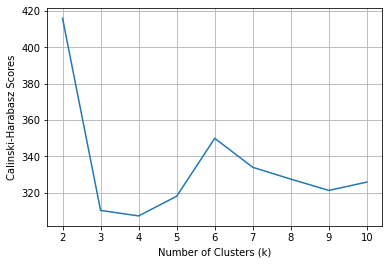

In [26]:
#visualizing calinski scores
plt.plot(range(2, 11), results_calinski)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Scores')
plt.grid()
plt.show()

In [ ]:
#I would use 4 for Calinski

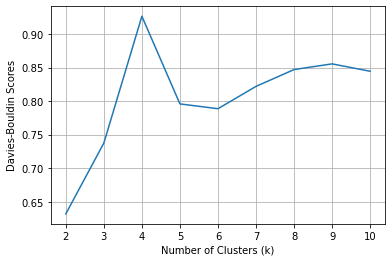

In [27]:
#visualizing davies scores
plt.plot(range(2, 11), results_davies)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Scores')
plt.grid()
plt.show()

In [ ]:
#I would choose 4 for Davies

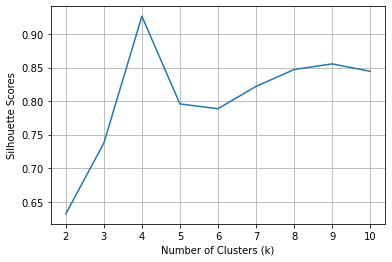

In [28]:
#visualizing silhouette scores
plt.plot(range(2, 11), results_davies)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Scores')
plt.grid()
plt.show()

In [ ]:
#I would choose 2 for Silhouette

In [29]:
kmeans_md = KMeans(n_clusters = 4, n_init = 20).fit(customers[['gender_0_1', 'age_0_1', 'income_0_1']])

## appending the cluster labels to the dataframe
customers['cluster'] = kmeans_md.labels_
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1,cluster
0,1,Male,19,15,39,0,0.019231,0.000000,3
1,2,Male,21,15,81,0,0.057692,0.000000,3
2,3,Female,20,16,6,1,0.038462,0.008197,2
3,4,Female,23,16,77,1,0.096154,0.008197,2
4,5,Female,31,17,40,1,0.250000,0.016393,2


In [30]:
#cluster 0
cluster_0 = customers[customers['cluster'] == 0].reset_index(drop = True)
cluster_0.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1,cluster
count,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,42.000000,42.0
mean,89.428571,51.928571,56.785714,37.095238,1.0,0.652473,0.342506,0.0
std,50.061982,7.478075,23.192236,17.014785,0.0,0.143809,0.190100,0.0
min,13.000000,40.000000,20.000000,5.000000,1.0,0.423077,0.040984,0.0
25%,52.000000,47.000000,42.250000,21.000000,1.0,0.557692,0.223361,0.0
50%,78.500000,50.000000,54.000000,43.000000,1.0,0.615385,0.319672,0.0
75%,118.750000,55.750000,66.500000,50.000000,1.0,0.725962,0.422131,0.0
max,197.000000,68.000000,126.000000,59.000000,1.0,0.961538,0.909836,0.0


In [ ]:
#Cluster 0 is middle aged women with an average age 51 with a 7 1/2 +- years difference with an average 
#annual income of $56,785

In [31]:
#cluster 1
cluster_1 = customers[customers['cluster'] == 1].reset_index(drop = True)
cluster_1.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1,cluster
count,31.000000,31.000000,31.000000,31.000000,31.0,31.000000,31.000000,31.0
mean,85.870968,57.806452,54.193548,36.645161,0.0,0.765509,0.321259,1.0
std,45.608290,8.005912,18.676936,18.236499,0.0,0.153960,0.153090,0.0
min,9.000000,47.000000,19.000000,3.000000,0.0,0.557692,0.032787,1.0
25%,57.000000,49.500000,43.500000,20.500000,0.0,0.605769,0.233607,1.0
50%,83.000000,59.000000,54.000000,43.000000,0.0,0.788462,0.319672,1.0
75%,109.500000,65.500000,63.000000,50.000000,0.0,0.913462,0.393443,1.0
max,179.000000,70.000000,93.000000,60.000000,0.0,1.000000,0.639344,1.0


In [ ]:
#Cluster 1 is middle aged men with an average age 57 with an 8 +- years difference with an average 
#annual income of $54,193

In [32]:
#cluster 2
cluster_2 = customers[customers['cluster'] == 2].reset_index(drop = True)
cluster_2.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1,cluster
count,70.000000,70.000000,70.000000,70.000000,70.0,70.000000,70.000000,70.0
mean,102.442857,29.800000,60.728571,60.185714,1.0,0.226923,0.374824,2.0
std,62.527822,6.137554,27.621626,23.677968,0.0,0.118030,0.226407,0.0
min,3.000000,18.000000,16.000000,6.000000,1.0,0.000000,0.008197,2.0
25%,44.500000,24.000000,39.000000,42.000000,1.0,0.115385,0.196721,2.0
50%,112.500000,31.000000,63.500000,60.500000,1.0,0.250000,0.397541,2.0
75%,157.500000,35.000000,78.000000,77.750000,1.0,0.326923,0.516393,2.0
max,196.000000,41.000000,120.000000,99.000000,1.0,0.442308,0.860656,2.0


In [ ]:
#Cluster 2 is middle aged women with an average age 29 with a 6 +- years difference with an average 
#annual income of $60,728

In [33]:
#cluster 3
cluster_3 = customers[customers['cluster'] == 3].reset_index(drop = True)
cluster_3.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),gender_0_1,age_0_1,income_0_1,cluster
count,57.000000,57.000000,57.000000,57.000000,57.0,57.000000,57.000000,57.0
mean,114.228070,30.017544,66.596491,54.964912,0.0,0.231107,0.422922,3.0
std,61.081333,7.920343,29.332369,30.175064,0.0,0.152314,0.240429,0.0
min,1.000000,18.000000,15.000000,1.000000,0.0,0.000000,0.000000,3.0
25%,66.000000,24.000000,48.000000,35.000000,0.0,0.115385,0.270492,3.0
50%,130.000000,31.000000,71.000000,59.000000,0.0,0.250000,0.459016,3.0
75%,167.000000,36.000000,86.000000,79.000000,0.0,0.346154,0.581967,3.0
max,200.000000,46.000000,137.000000,97.000000,0.0,0.538462,1.000000,3.0


In [ ]:
#Cluster 3 is middle aged men with an average age 30 with an 8 +- years difference with an average 
#annual income of $566,596

In [ ]:
#To improve this model, i would suggest changing the n_init to a higher value than 20, this would give a 
#better return as the clustering would run more times to give a better outcome with different seeds. 
#You could also add the other variables instead of just spending score 